In [1]:
import pandas as pd
import numpy as np

In [2]:
## Player of week
POTW = pd.read_csv('../data/raw/NBA_Player_of_the_Week.csv')
POTW.tail(10)

,Active season,Player,Team,Conference,Date,Position,Height,Weight,Age,Draft Year,Seasons in league,Season,Season short,Real_value
1177,1,Nikola Vucevic,Orlando Magic,East,"Nov 19, 2018",PF,7-0,260,28,2011,7,2018-2019,2019,0.5
1178,1,Anthony Davis,New Orleans Pelicans,West,"Nov 19, 2018",PF,6-10,253,25,2012,6,2018-2019,2019,0.5
1179,1,Pascal Siakam,Toronto Raptors,East,"Nov 12, 2018",F,6-9,230,25,2016,2,2018-2019,2019,0.5
1180,1,C.J. McCollum,Portland Trail Blazers,West,"Nov 12, 2018",G,6-3,190,27,2013,5,2018-2019,2019,0.5
1181,1,Victor Oladipo,Indiana Pacers,East,"Nov 5, 2018",G,6-4,210,26,2013,5,2018-2019,2019,0.5
1182,1,Russell Westbrook,Oklahoma City Thunder,West,"Nov 5, 2018",G,6-3,200,30,2008,10,2018-2019,2019,0.5
1183,1,Giannis Antetokounmpo,Milwaukee Bucks,East,"Oct 29, 2018",F,6-11,242,24,2013,5,2018-2019,2019,0.5
1184,1,Stephen Curry,Golden State Warriors,West,"Oct 29, 2018",G,6-3,190,30,2009,9,2018-2019,2019,0.5
1185,1,Kemba Walker,Charlotte Hornets,East,"Oct 22, 2018",G,6-1,184,28,2011,7,2018-2019,2019,0.5
1186,1,Nikola Jokic,Denver Nuggets,West,"Oct 22, 2018",C,7-0,250,24,2014,3,2018-2019,2019,0.5


In [3]:
## Salary
pd.set_option('display.max_columns', 999)
SLR = pd.read_csv('../data/cleaned/NBA_Salary.csv')
SLR.head()

,Player Name,Salary in $,Season End,Season Start,Team,Franchise
0,A.C. Green,1750000,1991,1990,LAL,Los Angeles Lakers
1,A.C. Green,1750000,1992,1991,LAL,Los Angeles Lakers
2,A.C. Green,1750000,1993,1992,LAL,Los Angeles Lakers
3,A.C. Green,1885000,1994,1993,PHX,Phoenix Suns
4,A.C. Green,6472600,1995,1994,PHX,Phoenix Suns


In [4]:
## Summary
SUM = pd.read_csv('../data/scraped/NBA_Yearly_Summary.csv')
SUM.tail(15)

,Year,League Champion,Most Valuable Player,Rookie of the Year,PPG Leader,RPG Leader,APG Leader,WS Leader
20,2005,San Antonio Spurs,Steve Nash,Emeka Okafor,Allen Iverson,Kevin Garnett,Steve Nash,Kevin Garnett
21,2006,Miami Heat,Steve Nash,Chris Paul,Kobe Bryant,Kevin Garnett,Steve Nash,Dirk Nowitzki
22,2007,San Antonio Spurs,Dirk Nowitzki,Brandon Roy,Kobe Bryant,Kevin Garnett,Steve Nash,Dirk Nowitzki
23,2008,Boston Celtics,Kobe Bryant,Kevin Durant,LeBron James,Dwight Howard,Chris Paul,Chris Paul
24,2009,Los Angeles Lakers,LeBron James,Derrick Rose,Dwyane Wade,Dwight Howard,Chris Paul,LeBron James
25,2010,Los Angeles Lakers,LeBron James,Tyreke Evans,Kevin Durant,Dwight Howard,Steve Nash,LeBron James
26,2011,Dallas Mavericks,Derrick Rose,Blake Griffin,Kevin Durant,Kevin Love,Steve Nash,LeBron James
27,2012,Miami Heat,LeBron James,Kyrie Irving,Kevin Durant,Dwight Howard,Rajon Rondo,LeBron James
28,2013,Miami Heat,LeBron James,Damian Lillard,Carmelo Anthony,Dwight Howard,Rajon Rondo,LeBron James
29,2014,San Antonio Spurs,Kevin Durant,Michael Carter-Williams,Kevin Durant,DeAndre Jordan,Chris Paul,Kevin Durant


## POW VS MVP

In [5]:
POTW_count = POTW.groupby(['Season short','Player','Team']).count()['Date'].reset_index().rename(columns = {'Date': 'POTW_Count'})
POTW_count.head()

,Season short,Player,Team,POTW_Count
0,1985,Alex English,Denver Nuggets,1
1,1985,Bernard King,New York Knicks,1
2,1985,Calvin Natt,Denver Nuggets,1
3,1985,Darrell Griffith,Utah Jazz,1
4,1985,Derek Smith,Los Angeles Clippers,2


In [6]:
## MVP 
MVP = SUM[['Year', 'Most Valuable Player']]
MVP.head()

,Year,Most Valuable Player
0,1985,Larry Bird
1,1986,Larry Bird
2,1987,Magic Johnson
3,1988,Michael Jordan
4,1989,Magic Johnson


In [7]:
potw_mvp = pd.merge(POTW_count,MVP, left_on = 'Season short', right_on= 'Year',how = 'left')
potw_mvp.loc[potw_mvp['Most Valuable Player'] == potw_mvp['Player'], 'Is_MVP'] = 'Yes'
potw_mvp.loc[potw_mvp['Most Valuable Player'] != potw_mvp['Player'], 'Is_MVP'] = 'No'
potw_mvp_new = potw_mvp[['Year','Player','Team','POTW_Count','Is_MVP']].copy()
potw_mvp_new.head(10)

,Year,Player,Team,POTW_Count,Is_MVP
0,1985,Alex English,Denver Nuggets,1,No
1,1985,Bernard King,New York Knicks,1,No
2,1985,Calvin Natt,Denver Nuggets,1,No
3,1985,Darrell Griffith,Utah Jazz,1,No
4,1985,Derek Smith,Los Angeles Clippers,2,No
5,1985,Dominique Wilkins,Atlanta Hawks,1,No
6,1985,Isiah Thomas,Detroit Pistons,1,No
7,1985,Jack Sikma,Seattle SuperSonics,1,No
8,1985,Kareem Abdul-Jabbar,Los Angeles Lakers,1,No
9,1985,Larry Bird,Boston Celtics,1,Yes


In [8]:
max_count = potw_mvp_new.groupby('Year').max()[['POTW_Count']].reset_index().rename(columns = {'POTW_Count': 'Max'})
max_count.head()

,Year,Max
0,1985,2
1,1986,4
2,1987,5
3,1988,3
4,1989,4


In [9]:
potw_mvp_sum = pd.merge(max_count, potw_mvp_new, on = ['Year'])
potw_mvp_sum.loc[potw_mvp_sum.Max == potw_mvp_sum.POTW_Count, 'Is_Max'] = 'Yes'
potw_mvp_sum.loc[potw_mvp_sum.Max != potw_mvp_sum.POTW_Count, 'Is_Max'] = 'No'

In [10]:
potw_mvp_sum.loc[(potw_mvp_sum.Is_MVP == 'Yes') & (potw_mvp_sum.Is_Max == 'Yes'), 'Group'] = 'Both'
potw_mvp_sum.loc[(potw_mvp_sum.Is_MVP == 'Yes') & (potw_mvp_sum.Is_Max == 'No'), 'Group'] = 'Either'
potw_mvp_sum.loc[(potw_mvp_sum.Is_MVP == 'No') & (potw_mvp_sum.Is_Max == 'Yes'), 'Group'] = 'Either'
potw_mvp_sum.loc[(potw_mvp_sum.Is_MVP == 'No') & (potw_mvp_sum.Is_Max == 'No'), 'Group'] = 'Neither'
labeled_case = (potw_mvp_sum.loc[(potw_mvp_sum.Year > 2000) & 
                                (potw_mvp_sum.Group == 'Either')].copy())
labeled_case['year_name'] = labeled_case['Year'].astype(str) +  ', ' + labeled_case['Player']
labeled_case.head()

,Year,Max,Player,Team,POTW_Count,Is_MVP,Is_Max,Group,year_name
287,2001,2,Chris Webber,Sacramento Kings,2,No,Yes,Either,"2001, Chris Webber"
343,2003,5,Kobe Bryant,Los Angeles Lakers,5,No,Yes,Either,"2003, Kobe Bryant"
392,2005,4,Allen Iverson,Philadelphia Sixers,4,No,Yes,Either,"2005, Allen Iverson"
420,2005,4,Steve Nash,Phoenix Suns,2,Yes,No,Either,"2005, Steve Nash"
421,2005,4,Tracy McGrady,Houston Rockets,4,No,Yes,Either,"2005, Tracy McGrady"


In [11]:
%load_ext rpy2.ipython

In [12]:
%R library(ggplot2)

array(['ggplot2', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], dtype='<U9')

In [13]:
%R -i potw_mvp_sum
%R -i labeled_case

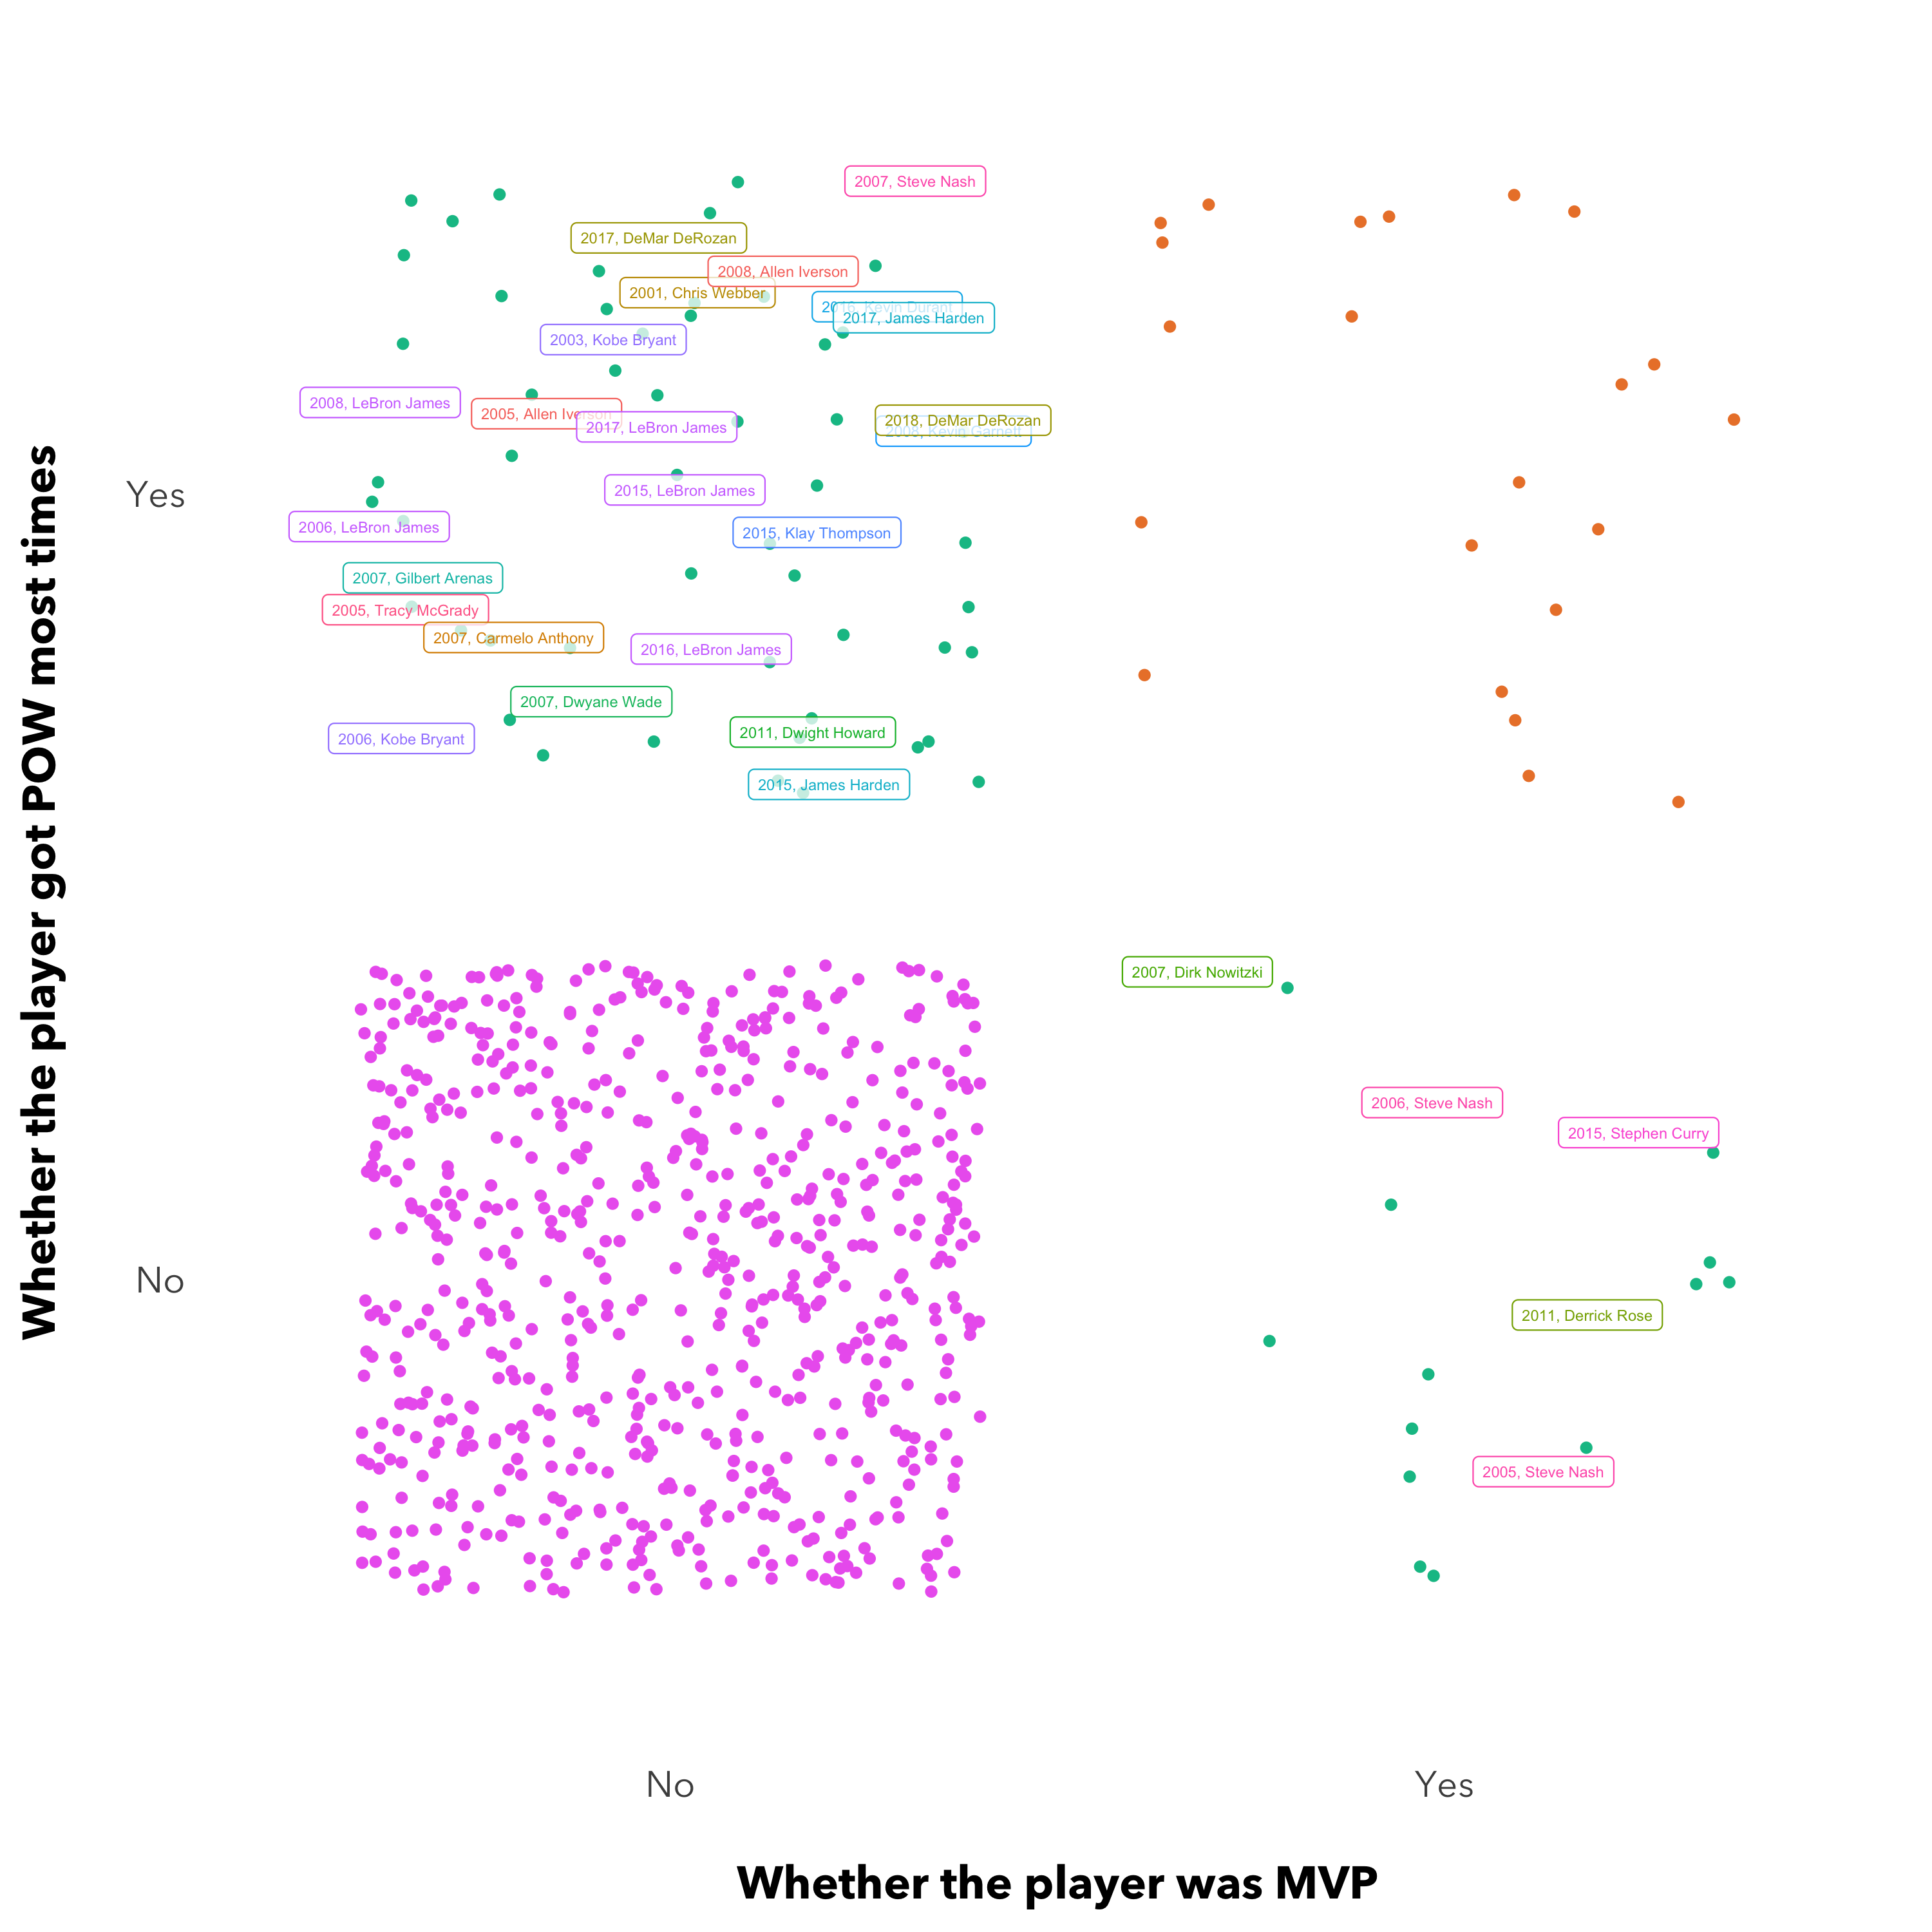

In [46]:
%%R -w 10 -h 10 --units in -r 300
(ggplot() + geom_jitter(aes(x = Is_MVP, y = Is_Max,color = Group), data = potw_mvp_sum) +
 theme_minimal(base_size = 17) +
 guides(colour = F) +
 geom_label(aes(x = Is_MVP, y = Is_Max, label = year_name, color = Player), 
            data = labeled_case, position = 'jitter', size = 2, alpha = 0.75) +
 ylab("Whether the player got POW most times \n") + 
 xlab("\nWhether the player was MVP") +
 theme(text = element_text(family = 'Avenir Next'),
      axis.title = element_text(face = 'bold'),
       panel.grid.major = element_blank(),
       panel.grid.minor = element_blank())
)

## POW VS Salary

In [15]:
slr_new = SLR.drop(columns = ['Season Start', 'Team'])
slr_potw = pd.merge(slr_new, POTW_count, left_on=['Player Name', 'Season End'], right_on=['Player','Season short'], how = 'left')
slr_potw.tail()

,Player Name,Salary in $,Season End,Franchise,Season short,Player,Team,POTW_Count
12410,C.J. Watson,333333,2019,Orlando Magic,NaN,NaN,NaN,NaN
12411,Miroslav Raduljica,252043,2019,Los Angeles Clippers,NaN,NaN,NaN,NaN
12412,Troy Williams,122741,2019,Houston Rockets,NaN,NaN,NaN,NaN
12413,Emeka Okafor,100000,2019,New Orleans Pelicans,NaN,NaN,NaN,NaN
12414,Demetrius Jackson,92857,2019,Boston Celtics,NaN,NaN,NaN,NaN


In [16]:
slr_potw.loc[slr_potw.Player.isna(), 'POTW_Count'] = 0
slr_potw['POTW_Count'] = slr_potw['POTW_Count']
slr_potw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12415 entries, 0 to 12414
Data columns (total 8 columns):
Player Name     12415 non-null object
Salary in $     12415 non-null int64
Season End      12415 non-null int64
Franchise       12415 non-null object
Season short    600 non-null float64
Player          600 non-null object
Team            600 non-null object
POTW_Count      12415 non-null float64
dtypes: float64(2), int64(2), object(4)
memory usage: 872.9+ KB


In [17]:
slr_potw_new = slr_potw.drop(columns= ['Season short','Player','Team']).rename(columns = {'Player Name': 'Player', 'Season End':'Year','Salary in $':'Salary'})
slr_potw_new['Salary'] = round(slr_potw_new['Salary'] /1000000, 4)
slr_potw_new.head()

,Player,Salary,Year,Franchise,POTW_Count
0,A.C. Green,1.7500,1991,Los Angeles Lakers,0.0
1,A.C. Green,1.7500,1992,Los Angeles Lakers,0.0
2,A.C. Green,1.7500,1993,Los Angeles Lakers,0.0
3,A.C. Green,1.8850,1994,Phoenix Suns,0.0
4,A.C. Green,6.4726,1995,Phoenix Suns,0.0


In [18]:
slr_potw_median = slr_potw_new.groupby('Year')[['Salary']].median().reset_index()
slr_potw_median.head()

,Year,Salary
0,1991,0.6500
1,1992,0.7350
2,1993,0.8135
3,1994,1.0740
4,1995,1.0967


In [19]:
%R -i slr_potw_new
%R -i slr_potw_median

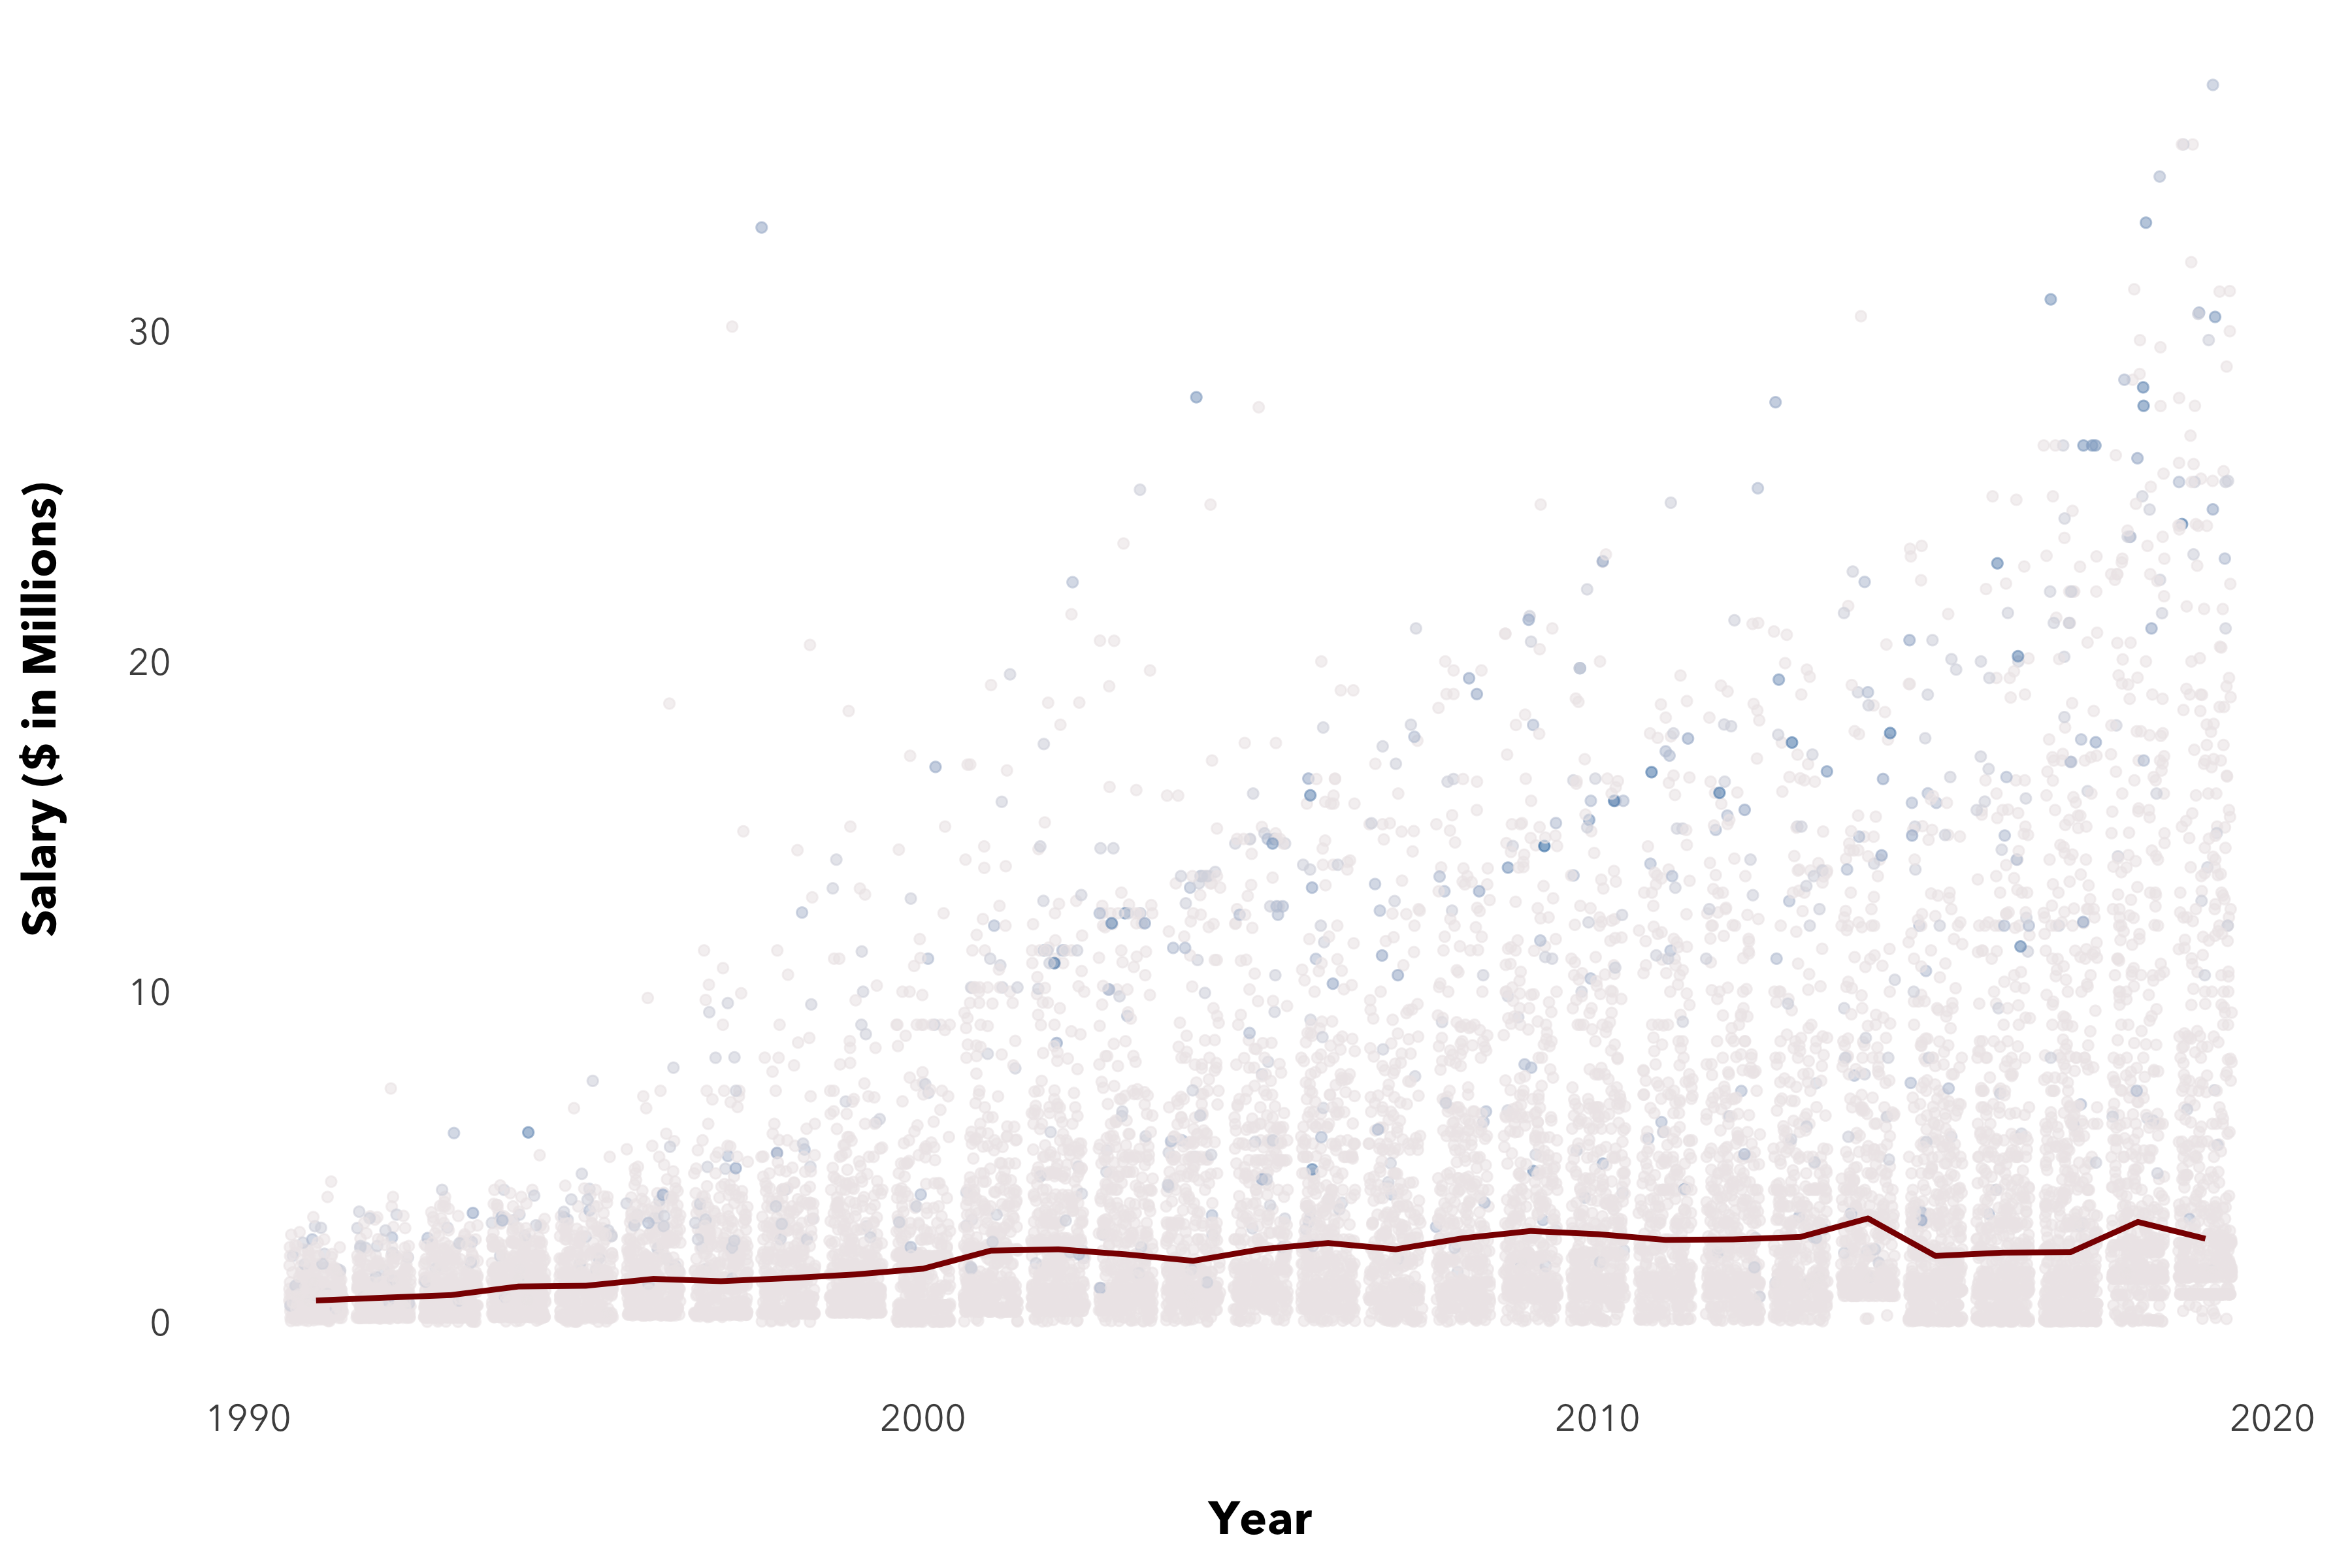

In [51]:
%%R -w 12 -h 8 --units in -r 300
ggplot() +
geom_jitter(aes(x = Year, y = Salary, color = POTW_Count), data = slr_potw_new, alpha = 0.6) +
theme_minimal(base_size = 17) +
geom_line(aes(x = Year, y = Salary), data = slr_potw_median, stat = "identity", color = 'red4', size = 1) +
xlab("\nYear") + 
ylab("Salary ($ in Millions) \n") +
scale_colour_gradient(low = 'snow2', high = 'steelblue') +
theme(text = element_text(family = 'Avenir Next'),
      axis.title = element_text(face = 'bold'),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank()) +
guides(colour = F, size = F)